<a href="https://colab.research.google.com/github/tom-mai-wichtig/tom-mai-wichtig/blob/main/Framework_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting dataset

In [38]:
!wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-1.tar.gz
!tar -xvf tasks_1-20_v1-1.tar.gz

--2024-11-04 22:15:55--  http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-1.tar.gz
Resolving www.thespermwhale.com (www.thespermwhale.com)... 50.31.160.191
Connecting to www.thespermwhale.com (www.thespermwhale.com)|50.31.160.191|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1282454 (1.2M) [application/x-gzip]
Saving to: ‘tasks_1-20_v1-1.tar.gz.3’

tasks_1-20_v1-1.tar 100%[===================>]   1.22M  4.82MB/s    in 0.3s    

2024-11-04 22:15:56 (4.82 MB/s) - ‘tasks_1-20_v1-1.tar.gz.3’ saved [1282454/1282454]

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tasksv11/
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tasks

Try numpy and a small activation function

In [39]:
import numpy as np
a = np.array ([1,2,3])
def gaussian(array):
    x = np.exp(-array**2)
    return x

result = gaussian(a)
expected = np.array([0.36787944117, 0.01831563888, 0.0001234098])
print(np.testing.assert_array_almost_equal(result, expected, decimal=10))



None


Writing Framework


In [40]:
import numpy as np
np.random.seed(1)
class Tensor ():
    """
    creators: list of tensors used in creation of current tensor
    creation_op: intructions creators used in creation process
    """
    def __init__ (self, data, autograd=False
                  , creators=None, creation_op=None,
                  id=None):
        self.data = np.array(data)
        self.creation_op= creation_op
        self.creators = creators
        self.grad = None
        self.autograd = autograd
        self.children = {} # count number of gradients from each child
        if id == None:
            id = np.random.randint(0,100000) # should different tensors has different id? not really cuz id is only for counting, even
        self.id = id                            # they have the same id, they still have different other values
        if creators != None:
            for c in creators: # keep track how many chidren a tensor hat
                if (self.id not in c.children):
                    c.children[self.id] =1
                else:
                    c.children[self.id] +=1

    def all_children_grads_accounted_for(self): # check tensor has received
        for id, cnt in self.children.items():   # all gradients from child
            if (cnt != 0) :
                return False
        return True

    def backward (self,grad= None, grad_origin=None):
        """
        Backward:
            -1 count for the parent Tensor of current Tensor: parent.children (==0 means no more grad from that Tensor)
            update grad
            passing its grad to parent.grad

        """
        if (self.autograd):
            if (grad is None):
                grad = Tensor(np.ones_like(self.data))
            # -1 count for parent Tensor
            if (grad_origin != None): # grad_origin == None: only for last children Tensor
                if (self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -=1

            # update grad
            if self.grad == None: # if grad was not initialized
                self.grad = grad
            else: # if grad already has a value, add new grad into that
                self.grad += grad
            assert grad.autograd == False # grad not have grads of their own

            # passing grad to parent Tensor
            if ((self.creators != None) and # not first_generation Tensors (first gen Tensors doesnt have creators)
             (self.all_children_grads_accounted_for() or (grad_origin ==None))): #all grad from children calculated or last_gen Tensor
                if (self.creation_op =="add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                if (self.creation_op =='neg'):
                    # backward: creator.grad = self.grad *-1 (becuz forwad: self = creator *-1)
                    self.creators[0].backward(self.grad.__neg__(), self)
                if (self.creation_op == 'mul'):
                    new = self.grad*self.creators[1]
                    self.creators[0].backward(new, self)
                    new = self.grad*self.creators[0]
                    self.creators[1].backward(new, self)
                if (self.creation_op == 'sub'):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad.__neg__(),self)
                if  (self.creation_op == 'mm'):
                    layer = self.creators[0]
                    weights = self.creators[1]
                    del_layer = self.grad.mm(weights.transpose())# cal next del_layer
                    layer.backward(del_layer, self) # passing to that layer
                    del_weights = self.grad.transpose().mm(layer).transpose()
                    weights.backward(del_weights, self)
                if (self.creation_op == 'transpose'):
                    self.creators[0].backward(self.grad.transpose())
                if ("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    ds = self.creators[0].data.shape[dim]
                    self.creators[0].backward(self.grad.expand(dim, ds))
                if ('expand' in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                if (self.creation_op == 'sigmoid'):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self* (ones - self)),self) # grad * deri2sigmoid (self * (one-self)
                if (self.creation_op == 'tanh'):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self*self)),self)
                if self.creation_op == 'relu':
                    self.creators[0].backward(self.grad * (self.data>0), self)
                if self.creation_op == 'index_select':
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_),-1)
                    for i in range (len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad),self)
                if self.creation_op == "cross_entropy":
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx),self)


    def __add__ (self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data + other.data, autograd = True,
                        creators = [self,other], creation_op = 'add')
        return (Tensor(self.data + other.data))

    def __neg__(self):
        if (self.autograd):
            return Tensor(self.data*-1, autograd = True,
                          creators = [self], creation_op = 'neg')
        return Tensor(self.data *-1)

    def __sub__(self, other):
        if (self.autograd):
            return Tensor(self.data - other.data, autograd = True,
                          creators = [self, other], creation_op ='sub')
        return Tensor (self.data - other.data)

    def __mul__(self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data * other.data, autograd = True,
                          creators = [self, other], creation_op = 'mul')
        return Tensor(self.data*other.data)

    def sum(self, dim):
        if self.autograd:
            return Tensor(self.data.sum(dim), autograd = True,
                          creators = [self], creation_op= "sum_" + str(dim))
        return Tensor(self.data.sum(dim)) # axis = dim

    def expand(self, dim, copies):
        new_shape = list(self.data.shape) + [copies]
        new_data = self.data.repeat(copies).reshape(new_shape)
        # transpose_cmd ist fur ab 3-D
        transpose_cmd = list(range(0,len(self.data.shape)))
        transpose_cmd.insert(dim, len(self.data.shape))

        new_data = new_data.transpose(transpose_cmd)
        if self.autograd:
            return Tensor(new_data, autograd = True,
                          creators = [self], creation_op = "expand_" +str(dim))
        return (Tensor(new_data))

    def transpose(self):
        if self.autograd:
            return Tensor (self.data.transpose(), autograd = True,
                           creators = [self], creation_op = "transpose")
        return Tensor(self.data.T)

    def mm(self,x):
        """matrix multiplication"""
        if self.autograd:
            return Tensor(self.data.dot(x.data), autograd= True,
                          creators=[self, x], creation_op = 'mm')
        return Tensor(self.data.dot(x.data))

    # add function for object calcultion
    def gaussian (self,x):
        if self.autograd:
            y = np.exp(-x**2)
            return Tensor(self.data.gaussian(x.data), autograd= True,
                          creators=[self, x], creation_op = 'gaussian')
        return Tensor(self.data)

    def index_select(self, indices):
        if self.autograd:
            new = Tensor (self.data[indices.data], autograd = True,
                          creators = [self], creation_op= "index_select")
            new.index_select_indices = indices
            return new
        return Tensor (self.data[indices.data])

    def cross_entropy(self, target_indices):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis = len(self.data.shape)-1,
                                       keepdims=True)
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -((np.log(p)*target_dist)).sum(1).mean()
        if self.autograd:
            out = Tensor(loss, autograd = True, creators=[self],
                         creation_op= 'cross_entropy')
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out
        return Tensor(loss)

    ## activation (nonlinearity layers)
    def sigmoid(self):
        if (self.autograd):
            return Tensor(1 / (1+ np.exp(-self.data)), autograd = True,
                          creators = [self], creation_op="sigmoid")
        return Tensor( 1 / (1 + np.exp(-self.data)))
    def tanh (self):
        if self.autograd:
            return Tensor(np.tanh(self.data), autograd= True,
                          creators = [self], creation_op='tanh')
        return Tensor(np.tanh(self.data))

    def relu (self):
        if self.autograd:
            return Tensor(self.data* (self.data>0), autograd = True,
                          creators = [self], creation_op = 'relu')
        return Tensor (self.data* (self.data>0))

    # magic funciton here only for String
    def __repr__(self):
        return str(self.data.__repr__())
    def __str__(self):
        return str(self.data.__str__())


class SGD():
    """
    Auto update weights
    IN: take weight list, update each weight
    """
    def __init__(self, parameters, alpha = 0.1):
        self.parameters = parameters
        self.alpha = alpha

    def zero(self):
        for p in self.parameters: # reset grad back to 0
            p.grad.data *=0
    def step (self, zero = True):
        for p in self.parameters:
            p.data -= p.grad.data * self.alpha  # update parameter
            if zero:
                p.grad.data *=0 # reset grad back to 0 for next iterations

class Layer():
    def __init__(self):
        """parameters = []
        get_parameter: return parameter"""
        self.parameters = list()
    def get_parameters(self):
        return self.parameters

class Linear(Layer):
    """Create weight layer between two layers,
    instead having to initialize weights, we can use this class
    weight and bias stored into Layer class (Linear is also a layer)
    *** always use input/output als 2-D array for this class
    IN: number of neuro in and out
    OUT:
        setup matrix weight: next_layer = pre_layer.mm(weight) + bias
        forward using input_data to next layer
    """
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs,n_outputs)*np.sqrt(2.0/n_inputs) # initialize weights
        self.weight = Tensor(W, autograd=True)  # converting into Tensor Class
        self.bias = Tensor(np.zeros(n_outputs), autograd= True)

        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward (self,input):
        return input.mm(self.weight)+ self.bias.expand(0,len(input.data)) # expand is for learning a batch

class Sequential(Layer):
    """
    loop each layer feed its outputs into next layer inputs
    layers: contain many layers of weight and bias between each hidden layer
    """
    def __init__(self, layers = list()):
        # storing layers class
        super().__init__()
        self.layers = layers # initiate layer
    def add (self,layer):
        self.layers.append(layer) # if we want to try more other layers than initiated layers
    def forward (self,input):
        for layer in self.layers: # for each between 2 layers
            input = layer.forward(input) # each layer class muss have forward
        return input        # function to call forward input
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params

# class calculating Cost function
class MSELoss(Layer):
    """Mean squared error"""
    def __init__(self):
        super().__init__()
    def forward(self, pred, target):
        return ((pred - target)*(pred-target)).sum(0)

class Tanh (Layer):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return input.tanh() # from Tensor then called in Sequential
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    def forward(self,input):
        return input.sigmoid() # from Tensor then called in Sequential

class Relu (Layer):
    def __init__(self):
        super().__init__()
    def forward (self, input):
        return input.relu()

class Embedding(Layer):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.dim = dim
        embed = (np.random.rand(vocab_size, dim)-0.5)/dim
        self.weight = Tensor(embed,autograd = True)
        self.parameters.append(self.weight)
    def forward (self, input):
        return self.weight.index_select(input)

class CrossEntropyLoss(Layer):
    def __init__(self):
        super().__init__()
    def forward(self, input, target):
        return input.cross_entropy(target)

class RNNCell(Layer):
    def __init__(self, n_inputs, n_hidden,n_output, activation = 'sigmoid'):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output

        if activation == 'sigmoid':
            self.activation = Sigmoid()
        elif activation == 'tanh':
            self.activation == Tanh()
        else:
            raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden) # input to hidden: embedding layer
        self.w_hh = Linear (n_hidden, n_hidden) # hiden to hiden: recurrent layer
        self.w_ho = Linear(n_hidden, n_output) # hidden to output: output layer

        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()

    def forward (self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden

    def init_hidden (self, batch_size = 1):
        return Tensor(np.zeros((batch_size, self.n_hidden)),autograd = True)

In [41]:
import sys, random, math
from collections import Counter


Try Framework with one dataset

In [42]:
f = open('tasksv11/en/qa1_single-supporting-fact_train.txt','r')

raw = f.readlines()
f.close()
tokens = list()
print(raw[0:10])

for line in raw[0:1000]:
    line = line.lower().replace("\n","").replace("\t"," ").split(" ")[1:]
    for word in line:
        if word == "":
            line.remove("") # remove empty string
    tokens.append(line)
print(tokens[0:10])

['1 Mary moved to the bathroom.\n', '2 John went to the hallway.\n', '3 Where is Mary? \tbathroom\t1\n', '4 Daniel went back to the hallway.\n', '5 Sandra moved to the garden.\n', '6 Where is Daniel? \thallway\t4\n', '7 John moved to the office.\n', '8 Sandra journeyed to the bathroom.\n', '9 Where is Daniel? \thallway\t4\n', '10 Mary moved to the hallway.\n']
[['mary', 'moved', 'to', 'the', 'bathroom.'], ['john', 'went', 'to', 'the', 'hallway.'], ['where', 'is', 'mary?', 'bathroom', '1'], ['daniel', 'went', 'back', 'to', 'the', 'hallway.'], ['sandra', 'moved', 'to', 'the', 'garden.'], ['where', 'is', 'daniel?', 'hallway', '4'], ['john', 'moved', 'to', 'the', 'office.'], ['sandra', 'journeyed', 'to', 'the', 'bathroom.'], ['where', 'is', 'daniel?', 'hallway', '4'], ['mary', 'moved', 'to', 'the', 'hallway.']]


Converting words to numbers

In [43]:
def create_vocab(tokens):
    vocab = set()
    for sent in tokens:
        for word in sent:
            vocab.add(word)
    return list(vocab)

def create_word2index(vocab):
    word2index = {}
    for i, word in enumerate(vocab):
        word2index[word] = i
    return word2index

def words2indices(tokens):
    indices = list()
    for sent in tokens:
        idx = list()
        for word in sent:
            idx.append(word2index[word])
        indices.append(idx)
    return indices

def all_sentences_same_length(tokens, length):
    new_tokens = list()
    for line in tokens:
        new_tokens.append(['-']*(length-len(line)) + line)
    return new_tokens

In [44]:
## same length (6 in this case)

tokens = all_sentences_same_length(tokens, 6)
print (tokens[1])
vocab = create_vocab(tokens)
vocab_size = len(vocab)

word2index = create_word2index(vocab)
indices = words2indices(tokens)
print(indices)

['-', 'john', 'went', 'to', 'the', 'hallway.']
[[30, 8, 17, 34, 11, 5], [30, 27, 13, 34, 11, 12], [30, 18, 32, 29, 26, 19], [31, 13, 21, 34, 11, 12], [30, 14, 17, 34, 11, 2], [30, 18, 32, 3, 38, 37], [30, 27, 17, 34, 11, 39], [30, 14, 23, 34, 11, 5], [30, 18, 32, 3, 38, 37], [30, 8, 17, 34, 11, 12], [30, 31, 33, 34, 11, 39], [30, 18, 32, 3, 28, 22], [27, 13, 21, 34, 11, 2], [30, 27, 17, 34, 11, 35], [30, 18, 32, 24, 26, 9], [30, 14, 33, 34, 11, 39], [30, 14, 13, 34, 11, 5], [30, 18, 32, 24, 26, 4], [30, 8, 13, 34, 11, 35], [30, 31, 17, 34, 11, 12], [30, 18, 32, 24, 26, 4], [30, 27, 13, 34, 11, 2], [30, 27, 33, 34, 11, 39], [30, 18, 32, 24, 26, 4], [30, 31, 23, 34, 11, 35], [30, 31, 33, 34, 11, 12], [30, 18, 32, 1, 28, 9], [30, 27, 13, 34, 11, 35], [30, 27, 33, 34, 11, 39], [30, 18, 32, 3, 38, 22], [30, 8, 13, 34, 11, 35], [30, 27, 23, 34, 11, 5], [30, 18, 32, 1, 26, 4], [30, 14, 23, 34, 11, 12], [30, 27, 23, 34, 11, 2], [30, 18, 32, 29, 15, 19], [30, 27, 23, 34, 11, 5], [30, 14, 23, 34

In [45]:
for i in range (len(tokens)):
    if len(indices[i]) != len(tokens[i]):
        print(i)

Setup for training

In [46]:
data = np.array (indices)
embed = Embedding(vocab_size = len(vocab), dim = 16)
model = RNNCell(n_inputs = 16, n_hidden=16, n_output=len(vocab))

criterion = CrossEntropyLoss()

params = model.get_parameters() + embed.get_parameters()
optim = SGD(parameters= params, alpha = 0.05)

iterations = list()
loss_isterations = list()


Train

In [47]:
for iter in range (1001):
    batch_size = 100
    total_loss = 0
    hidden = model.init_hidden(batch_size = batch_size)

    for t in range (5):
        input = Tensor(data[0:batch_size,t], autograd =True)
        rnn_input = embed.forward(input = input)
        output, hidden = model.forward(input= rnn_input, hidden=hidden)

    target = Tensor(data[0:batch_size, t+1], autograd = True)
    loss = criterion.forward(output, target)
    loss.backward()
    optim.step()
    total_loss += loss.data

    if iter % 200 == 0:
        p_c = (target.data == np.argmax(output.data, axis=1)).mean()
        print_loss = total_loss/(len(data)/batch_size)
        iterations.append(iter)
        loss_isterations.append(print_loss)



Graphing performance

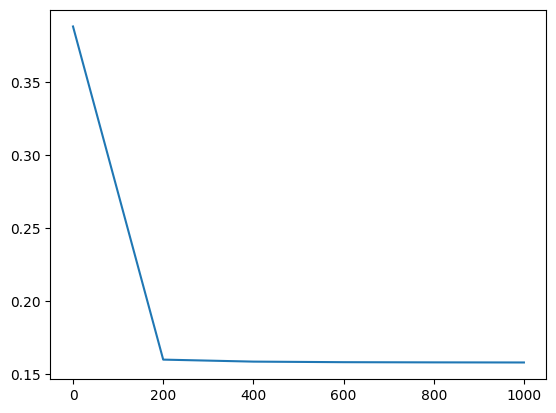

In [48]:
import matplotlib.pyplot as plt
plt.plot(iterations, loss_isterations)

In [50]:
# test:
batch_size =1
hidden = model.init_hidden(batch_size= batch_size)
for t in range (5):
    input = Tensor(data[0:batch_size, t], autograd = True)
    rnn_input = embed.forward(input=input)
    output, hidden = model.forward(input=rnn_input, hidden=hidden)

target = Tensor(data[0:batch_size, t+1],autograd=True)
loss = criterion.forward(output, target)

ctx = ""
for idx in data[0:batch_size][0][0:-1]:
    ctx += vocab[idx] + ' '
print("Context:", ctx)
print("Pred: ", vocab[output.data.argmax()])
print("True: ", vocab [target.data.argmax()])

Context: - mary moved to the 
Pred:  garden.
True:  kitchen
